In [18]:
import tensorflow as tf 
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
import os 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd 
import matplotlib.pyplot as plt

### Here prepare the folder if does not exist

In [3]:
# you need the current working directory NB: works both windows and linux 
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

if not os.path.exists(f"{current_working_directory}/Datasets"):
    os.makedirs(f"{current_working_directory}/Datasets")

print(f"[DATASET] PUT THE DATASET here: {current_working_directory}/Datasets")


[DATASET] PUT THE DATASET here: c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion/Datasets


In [4]:
# get the directory where I want to download the dataset
path_of_dataset = os.path.join(*['..', current_working_directory, 'Datasets', 'Most_Stolen_Cars'])
print(f"[DIR] The directory of the current dataset is {path_of_dataset}")

[DIR] The directory of the current dataset is c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion\Datasets\Most_Stolen_Cars


### Data prep

In [5]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    """
    This function help you to load the data dynamically 
    :param data_set_path: (str) put the path created in the previous cell (is the dataset path) 
    :param target_size: (tuple) the desired size of the images  
    :return: 
        - array of images 
        - array with labels 
        - list of labels name (this is used for better visualization)
    """
    try:
        dataset, labels, name_of_the_labels = list(), list(), list() 
        # let s loop here and we try to discover how many class we have 
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(*[data_set_path, class_name])
            print(f"[WALK] I am walking into {full_path_the_data}")
            
            # add the list to nam _list
            name_of_the_labels.append(class_name)
            
            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])
                
                # add the class number 
                labels.append(class_number)
                
                if target_size is None:
                    # let s load the image 
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)
                
                # transform PIL object in image                    
                image = tf.keras.utils.img_to_array(image)
                
                # add the image to the ds list 
                dataset.append(image)
                
        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

#### Load the data
    a. Target size: (112, 112, 3)
    b. if for some reason your pc crash saying Out of Memory reduce half the target size

In [6]:
data, labels, label_names = load_the_data_and_the_labels(data_set_path=path_of_dataset, target_size=(112, 112, 3))

[WALK] I am walking into c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion\Datasets\Most_Stolen_Cars\chevrolet_impala_2008
[WALK] I am walking into c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion\Datasets\Most_Stolen_Cars\chevrolet_silverado_2004
[WALK] I am walking into c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion\Datasets\Most_Stolen_Cars\dodge_ram_2001
[WALK] I am walking into c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion\Datasets\Most_Stolen_Cars\ford_f150_2006
[WALK] I am walking into c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion\Datasets\Most_Stolen_Cars\gmc_sierra_2012
[WALK] I am walking into c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion\Datasets\Most_Stolen_Cars\honda_accord_1997
[WALK] I am walking into c:\Users\legion\Documents\Studies\Computer Vision and Sensor Fusion\Datasets\Most_Stolen_Cars\honda_civic_1998
[WALK] I am walking into c:\Users\legio

### normalize the data here

In [7]:
data = data / 255.0

### Convert the data to one hot encoding (use the sklearn function)

In [8]:
# here we have to one hot encode the labes
def make_the_one_hot_encoding(labels_to_transform):
    try:
        enc = OneHotEncoder(handle_unknown='ignore')
        # this is a trick to figure the array as 2d array instead of list 
        temp = np.reshape(labels_to_transform, (-1, 1))
        labels_to_transform = enc.fit_transform(temp).toarray()
        print(f'[ONE HOT ENCODING] Labels are one-hot-encoded: {(labels_to_transform.sum(axis=1) - np.ones(labels_to_transform.shape[0])).sum() == 0}')
        return labels_to_transform
    except Exception as ex:
        print(f"[EXCEPTION] Make the one hot encoding throws exception {ex}")

In [9]:
labels_encoded = make_the_one_hot_encoding(labels)

[ONE HOT ENCODING] Labels are one-hot-encoded: True


# split the data in train set and test set 
    a. use 0.3 as split factor 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.3, random_state=42)

### Create a CNN with the following characteristics
        a. Input layer
        b. As base model use VGG16:
            i. Weights: imagenet
            ii. Include_top: False
            iii. Input_shape the target shape described in point 1. 
        c. Add a flatten layer 
        d. Add a Dense layer with 512 units and a dropout layer with 0.2 unit.
        e. Add a Dense layer with 256 units and a dropout layer with 0.2 unit.
        f. Add the final classifier with the correct number of units and the suitable activation.

![alt text](assignment_2_tl.png "CNN with tl")

In [20]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))
# Freeze the base model layers
for layer in base_model.layers:
    if 'block5_conv2' in layer.name or 'block5_conv3' in layer.name or 'block5_pool' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0     

### Set the layer block5_conv2, block5_conv3, block5_pool trainable 
    Important: you can make a function when you create a CNN within the option of make layers trainable or not is up to you!

In [34]:
# Done in the above cell

### Train the model 
    a. set the batch size 32 (if your PC go Out of memory lower this number half)
    b. set epochs to 15

In [32]:
model.fit(X_train, y_train, batch_size=32, epochs=15)

Epoch 1/15
130/130 [==============================] - 58s 449ms/step - loss: 0.0871 - accuracy: 0.9766
Epoch 2/15
130/130 [==============================] - 58s 446ms/step - loss: 0.0209 - accuracy: 0.9949
Epoch 3/15
130/130 [==============================] - 58s 447ms/step - loss: 0.0110 - accuracy: 0.9954
Epoch 4/15
130/130 [==============================] - 58s 447ms/step - loss: 0.0388 - accuracy: 0.9903
Epoch 5/15
130/130 [==============================] - 60s 458ms/step - loss: 0.0244 - accuracy: 0.9940
Epoch 6/15
130/130 [==============================] - 58s 446ms/step - loss: 0.0249 - accuracy: 0.9918
Epoch 7/15
130/130 [==============================] - 58s 445ms/step - loss: 0.0705 - accuracy: 0.9799
Epoch 8/15
130/130 [==============================] - 58s 447ms/step - loss: 0.0634 - accuracy: 0.9816
Epoch 9/15
130/130 [==============================] - 58s 446ms/step - loss: 0.0362 - accuracy: 0.9906
Epoch 10/15
130/130 [==============================] - 58s 447ms/step - l

56/56 [==============================] - 21s 371ms/step
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       297
           1       0.74      0.64      0.69       244
           2       0.57      0.53      0.55       142
           3       0.75      0.77      0.76       257
           4       0.59      0.49      0.54       124
           5       0.70      0.62      0.66       176
           6       0.65      0.84      0.73       239
           7       0.57      0.38      0.46       102
           8       0.57      0.54      0.55       103
           9       0.53      0.54      0.54        90

    accuracy                           0.67      1774
   macro avg       0.64      0.62      0.62      1774
weighted avg       0.67      0.67      0.66      1774



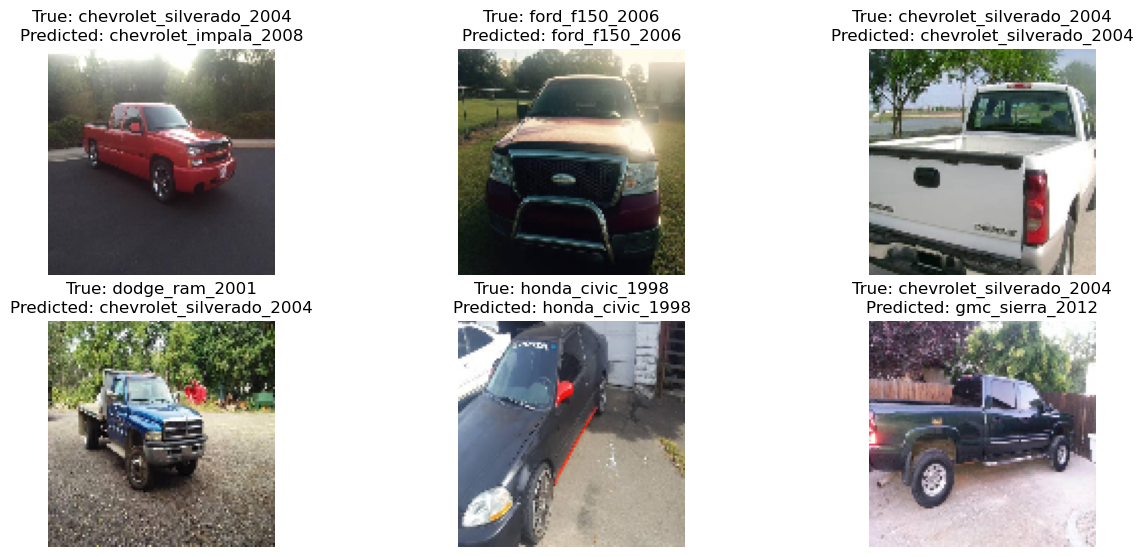

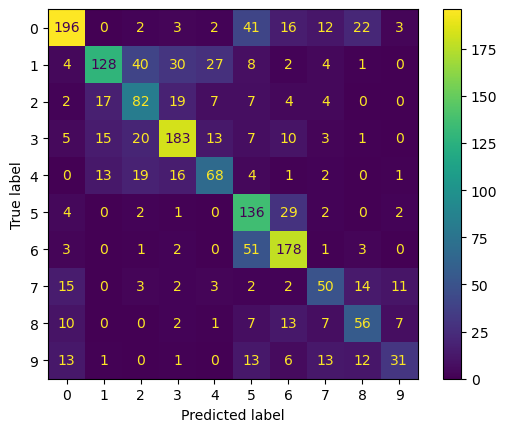

In [33]:
# Make predictions on test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred))

# Visualize some predictions
num_images = 6
random_indices = np.random.choice(range(len(X_test)), num_images, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[idx])
    plt.title(f'True: {label_names[y_true[idx]]}\nPredicted: {label_names[y_pred[idx]]}')
    plt.axis('off')
plt.show()

cm = confusion_matrix(y_true, y_pred_new)
ConfusionMatrixDisplay(cm).plot()

### evaluate the model and record the accuracy score.

In [34]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {accuracy:.4f}\nLoss: {loss:.4f}')


56/56 [==============================] - 21s 367ms/step - loss: 2.1141 - accuracy: 0.6674
Test Accuracy: 0.6674
Loss: 2.1141


### Load again the CNN and set all the base model layers to not trainable.

In [24]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

# Freeze the base model layers
base_model.trainable = False

new_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compile the new_model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print new_model summary
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 4608)              0         
                                                                 
 dense_27 (Dense)            (None, 512)               2359808   
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 10)               

### Repeat the train and evaluation steps

In [25]:
new_model.fit(X_train, y_train, batch_size=32, epochs=15)

Epoch 1/15
130/130 [==============================] - 51s 388ms/step - loss: 1.7642 - accuracy: 0.3389
Epoch 2/15
130/130 [==============================] - 47s 362ms/step - loss: 1.3528 - accuracy: 0.4842
Epoch 3/15
130/130 [==============================] - 49s 381ms/step - loss: 1.1147 - accuracy: 0.5731
Epoch 4/15
130/130 [==============================] - 48s 367ms/step - loss: 0.9373 - accuracy: 0.6425
Epoch 5/15
130/130 [==============================] - 49s 378ms/step - loss: 0.7694 - accuracy: 0.7121
Epoch 6/15
130/130 [==============================] - 48s 366ms/step - loss: 0.6846 - accuracy: 0.7399
Epoch 7/15
130/130 [==============================] - 48s 366ms/step - loss: 0.5551 - accuracy: 0.7955
Epoch 8/15
130/130 [==============================] - 52s 400ms/step - loss: 0.4540 - accuracy: 0.8371
Epoch 9/15
130/130 [==============================] - 49s 376ms/step - loss: 0.3799 - accuracy: 0.8622
Epoch 10/15
130/130 [==============================] - 49s 376ms/step - l

In [35]:
new_loss, new_accuracy = new_model.evaluate(X_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {new_accuracy:.4f}\nLoss: {new_loss:.4f}')

56/56 [==============================] - 21s 366ms/step - loss: 1.6921 - accuracy: 0.6246
Test Accuracy: 0.6246
Loss: 1.6921


### What happen? Why?

On evaluating the previous and new model, it can be seen that there is only a slight difference between the values of accuracy and loss. These results suggest that, in this particular case and with the given dataset, the additional fine-tuning of some layers in the base model did not lead to a significant improvement in model performance. The base model's pre-trained weights, even when frozen, still contribute useful features to the model, allowing it to achieve comparable performance to the model with some trainable layers.

### Make and visualize some predictions. 

56/56 [==============================] - 22s 389ms/step
              precision    recall  f1-score   support

           0       0.78      0.66      0.71       297
           1       0.74      0.52      0.61       244
           2       0.49      0.58      0.53       142
           3       0.71      0.71      0.71       257
           4       0.56      0.55      0.56       124
           5       0.49      0.77      0.60       176
           6       0.68      0.74      0.71       239
           7       0.51      0.49      0.50       102
           8       0.51      0.54      0.53       103
           9       0.56      0.34      0.43        90

    accuracy                           0.62      1774
   macro avg       0.60      0.59      0.59      1774
weighted avg       0.64      0.62      0.62      1774



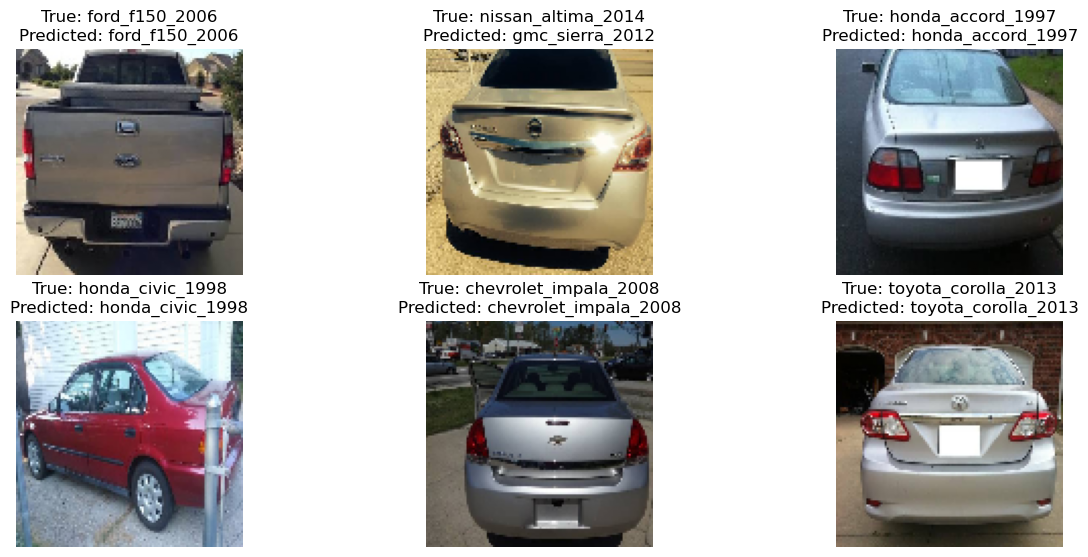

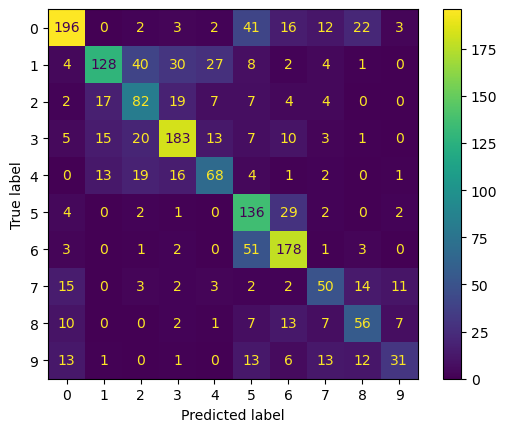

In [30]:
# Make predictions on test data

y_pred_prob_new = new_model.predict(X_test)
y_pred_new = np.argmax(y_pred_prob_new, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_new))

# Visualize some predictions
num_images = 6
random_indices = np.random.choice(range(len(X_test)), num_images, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[idx])
    plt.title(f'True: {label_names[y_true[idx]]}\nPredicted: {label_names[y_pred_new[idx]]}')
    plt.axis('off')
plt.show()

cm = confusion_matrix(y_true, y_pred_new)
ConfusionMatrixDisplay(cm).plot()